# Foundations of Data Science Final Project  

## **Causal Effect of Hours Worked per Week on Stress Levels**  

#### **Group Members**  
- **Avadhoot Kulkarni**  
  NetID: `ak10576`  
- **Emma Obermiller**  
  NetID: `elo2998`  
- **Odette Kuehn**  
  NetID: `odk6560`  

**Link to Project Screencast:** [Causal Effect of Hours Worked per Week on Stress Levels](https://drive.google.com/file/d/15RkZEFBw0rdqt4ImXo8iPsXsb2OBsWee/view?usp=sharing)

**Introduction:**

In recent years, multiple countries across Europe have piloted the 4-day work week, sparking widespread interest in its effects on productivity and employee well-being. Central to this debate is the question: Does working fewer hours per week reduce or increase stress levels? Understanding the causal relationship between hours worked per week and stress levels is critical for informing workplace policies aimed at improving employee mental health and productivity.

In 2020, the COVID-19 pandemic brought about a surge in remote work, presenting both challenges and opportunities for achieving work-life balance. This shift introduced unprecedented variability in employee stress levels, as some employees transitioned to partial or full remote work. The effects of working remotely, in hybrid settings, or onsite have been extensively debated, particularly concerning their impact on stress and productivity. To gain a comprehensive understanding of the interplay between these factors, our analysis considers work location as a confounder to identify any additional effects.

The dataset utilized for this project comes from Kaggle (https://www.kaggle.com/datasets/waqi786/remote-work-and-mental-health/data). It provides insights into the relationships between work environments and stress levels, offering a foundation for exploring how different work arrangements influence employee well-being.

The dataset contains three key variables for our analysis:
Treatment: Hours worked per week, modeled as a continuous variable with whole numbers ranging from 20 to 60.
Outcome: Stress levels, modeled as an ordered categorical variable with three levels: Low, Medium, and High.
Confound: Work location, modeled as a categorical variable with three categories: Remote, Hybrid, and Onsite.

Our statistical model operationalizes this question through Ordered Logistic Regression, where stress level is the outcome variable. The treatment variable, hours worked per week, will be modeled as a continuous variable following a Gaussian distribution. To adjust for work location as a confounding variable, the model is modified by using additional slope terms to represent the relationships between hours worked and stress level for each of the three categories of work location. This approach allows us to isolate the effect of hours worked on stress levels while accounting for variability introduced by the work environment.


In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp
import pytensor.tensor as pt
import seaborn as sns
from scipy import stats
from enum import IntEnum

from scipy import stats

from scipy.special import expit as logistic
import kagglehub
import os

In [ ]:
# for enabling animations
from IPython.display import HTML

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
# utility function for standardizing variables
def standardize(series):
    return (series - series.mean()) / series.std()

1. Load the dataset
2. Initialize priors
3. Prior predictive simulation
4. Build model (w and w/o confound)
5. Compare the models (contrast maybe?)
6. Thoughts/analysis  

In [ ]:
# downloading the latest version of the dataset
path = kagglehub.dataset_download("iramshahzadi9/remote-work-and-mental-health")
print("Path to dataset files:", path)

100%|██████████| 93.0k/93.0k [00:00<00:00, 36.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/iramshahzadi9/remote-work-and-mental-health/versions/1


In [ ]:
# creating a csv name for the dataset, to be able to read into it
csv_file = os.path.join(path, "Impact_of_Remote_Work_on_Mental_Health.csv")

In [ ]:
df = pd.read_csv(csv_file, header=0)
df.head()

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,Stress_Level,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,Medium,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,Medium,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,Medium,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,High,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,High,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America


### **Variable Details**  
- **Treatment**: `Hours_Worked_Per_Week`  
- **Output Variable**: `Stress_Level`  
- **Confound**: `Work_Location`

Data Analysis:

The dataset used in this analysis comes from Kaggle’s Remote Work and Mental Health Dataset. It includes three primary variables: hours worked per week (Hours_Worked_Per_Week), which is a discrete value in the range from 20 to 60; stress level (Stress_Level), an ordered categorical variable with three levels (Low, Medium, and High); and work location (Work_Location) a categorical variable with three categories (Onsite, Hybrid, and Remote).

A key characteristic of this dataset is that it has no missing values in the relevant columns, eliminating the need for imputation or data cleaning. Both stress level and work location were initially provided as string categories, making encoding straightforward. Stress levels were encoded as integers (Low as 0, Medium as 1, and High as 2) and treated as ordered categorical data. Similarly, work location was encoded as Onsite as 0, Hybrid as 1, and Remote as 2, though it was modeled as a nominal variable, as the categories do not have an inherent ranking. These characteristics ensure the dataset is well-prepared for the analysis.

In terms of dataset statistics, the distribution of hours worked per week spans a range from 20 to 60, with relatively even representation across this range. The stress levels are approximately evenly distributed among the three categories—Low, Medium, and High—indicating a balanced dataset for outcome analysis. Similarly, work location categories (Onsite, Hybrid, and Remote) are also evenly represented, ensuring no single category dominates the analysis. This balance across variables allows for robust modeling and unbiased interpretation of results.


As seen in the check below, we do not have any Null values in the columns that we are using, thus do not need to adjust any rows.

In [ ]:
df.isnull().sum()

,0
Employee_ID,0
Age,0
Gender,0
Job_Role,0
Industry,0
Years_of_Experience,0
Work_Location,0
Hours_Worked_Per_Week,0
Number_of_Virtual_Meetings,0
Work_Life_Balance_Rating,0


In [ ]:
# make Stress_Level into ordered categorical data
# ordered means 0 = low, 1 = medium, and 2 = high
df["stress_new"] = pd.Categorical(
    df.Stress_Level.values,
    categories=[
        "Low",
        "Medium",
        "High"
    ],
    ordered=True,
)
df["stress_new"] = df.stress_new.cat.codes
df.head()

,Employee_ID,Age,Gender,Job_Role,Industry,Years_of_Experience,Work_Location,Hours_Worked_Per_Week,Number_of_Virtual_Meetings,Work_Life_Balance_Rating,...,Mental_Health_Condition,Access_to_Mental_Health_Resources,Productivity_Change,Social_Isolation_Rating,Satisfaction_with_Remote_Work,Company_Support_for_Remote_Work,Physical_Activity,Sleep_Quality,Region,stress_new
0,EMP0001,32,Non-binary,HR,Healthcare,13,Hybrid,47,7,2,...,Depression,No,Decrease,1,Unsatisfied,1,Weekly,Good,Europe,1
1,EMP0002,40,Female,Data Scientist,IT,3,Remote,52,4,1,...,Anxiety,No,Increase,3,Satisfied,2,Weekly,Good,Asia,1
2,EMP0003,59,Non-binary,Software Engineer,Education,22,Hybrid,46,11,5,...,Anxiety,No,No Change,4,Unsatisfied,5,NaN,Poor,North America,1
3,EMP0004,27,Male,Software Engineer,Finance,20,Onsite,32,8,4,...,Depression,Yes,Increase,3,Unsatisfied,3,NaN,Poor,Europe,2
4,EMP0005,49,Male,Sales,Consulting,32,Onsite,35,12,2,...,NaN,Yes,Decrease,3,Unsatisfied,3,Weekly,Average,North America,2


Below is the analysis of the dataset, no configuring, just to understand the spread of the observed data between the amount of hours worked per week.

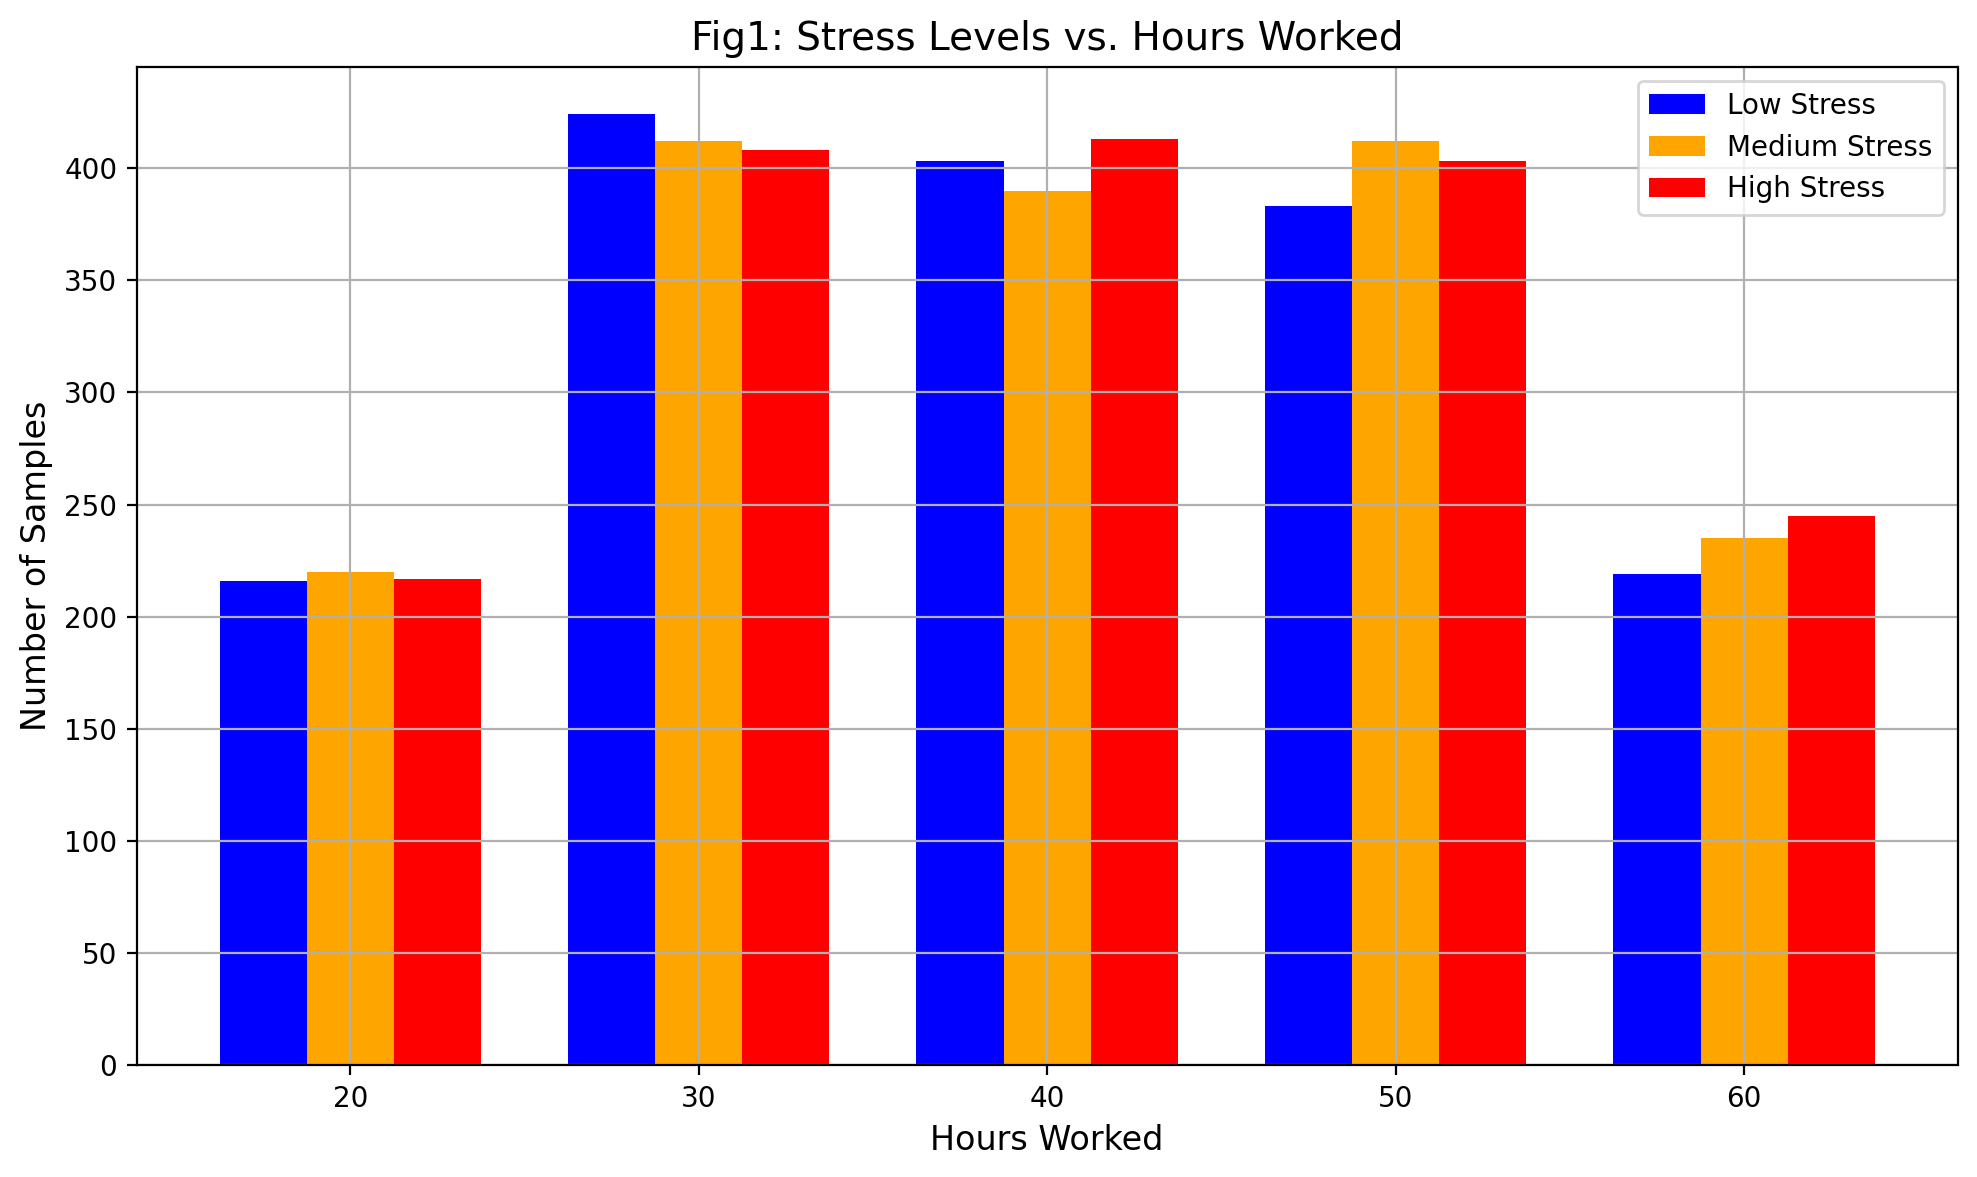

In [ ]:
# hour values from the dataset
hours = [20,30,40,50,60]
H = list(df["Hours_Worked_Per_Week"])
S = list(df.stress_new.values)

stress_low_total = {
    20:0,
    30:0,
    40:0,
    50:0,
    60:0
}
stress_med_total = stress_low_total.copy()
stress_high_total = stress_low_total.copy()

for i,h in enumerate(H):
  if h < 25:
    hour_val = 20
  elif h >= 25 and h < 35:
    hour_val = 30
  elif h >= 35 and h < 45:
    hour_val = 40
  elif h >= 45 and h < 55:
    hour_val = 50
  elif h >=55 and h<65:
    hour_val = 60
  else:
    hour_val = 100

  value = S[i]
  if value  == 0:
    stress_low_total[hour_val] = stress_low_total.get(hour_val,0) + 1
  elif value == 1:
    stress_med_total[hour_val] = stress_med_total.get(hour_val,0) + 1
  else:
    stress_high_total[hour_val] = stress_high_total.get(hour_val,0) + 1


hours_stress_low = {
    'hours': list(stress_low_total.keys()),
    'stress': list(stress_low_total.values())
}
hours_stress_med = {
    'hours': list(stress_med_total.keys()),
    'stress': list(stress_med_total.values())
}

hours_stress_high = {
    'hours': list(stress_high_total.keys()),
    'stress': list(stress_high_total.values())
}

bar_width = 0.25
# positions of the bars on the x-axis
x_pos = np.arange(len(hours))

# figure and axis
plt.figure(figsize=(10, 6))

# create bars for low, medium, and high stress levels
plt.bar(x_pos - bar_width, hours_stress_low['stress'], width=bar_width, label='Low Stress', color='blue')
plt.bar(x_pos, hours_stress_med['stress'], width=bar_width, label='Medium Stress', color='orange')
plt.bar(x_pos + bar_width, hours_stress_high['stress'], width=bar_width, label='High Stress', color='red')

# titles and labels
plt.title('Fig1: Stress Levels vs. Hours Worked', fontsize=14)
plt.xlabel('Hours Worked', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
# set the x-axis ticks to be at the center of the bars
plt.xticks(x_pos, hours)

# legend
plt.legend()

# add grid for easier reading
plt.grid(True)

# show the plot
plt.tight_layout()
plt.show()

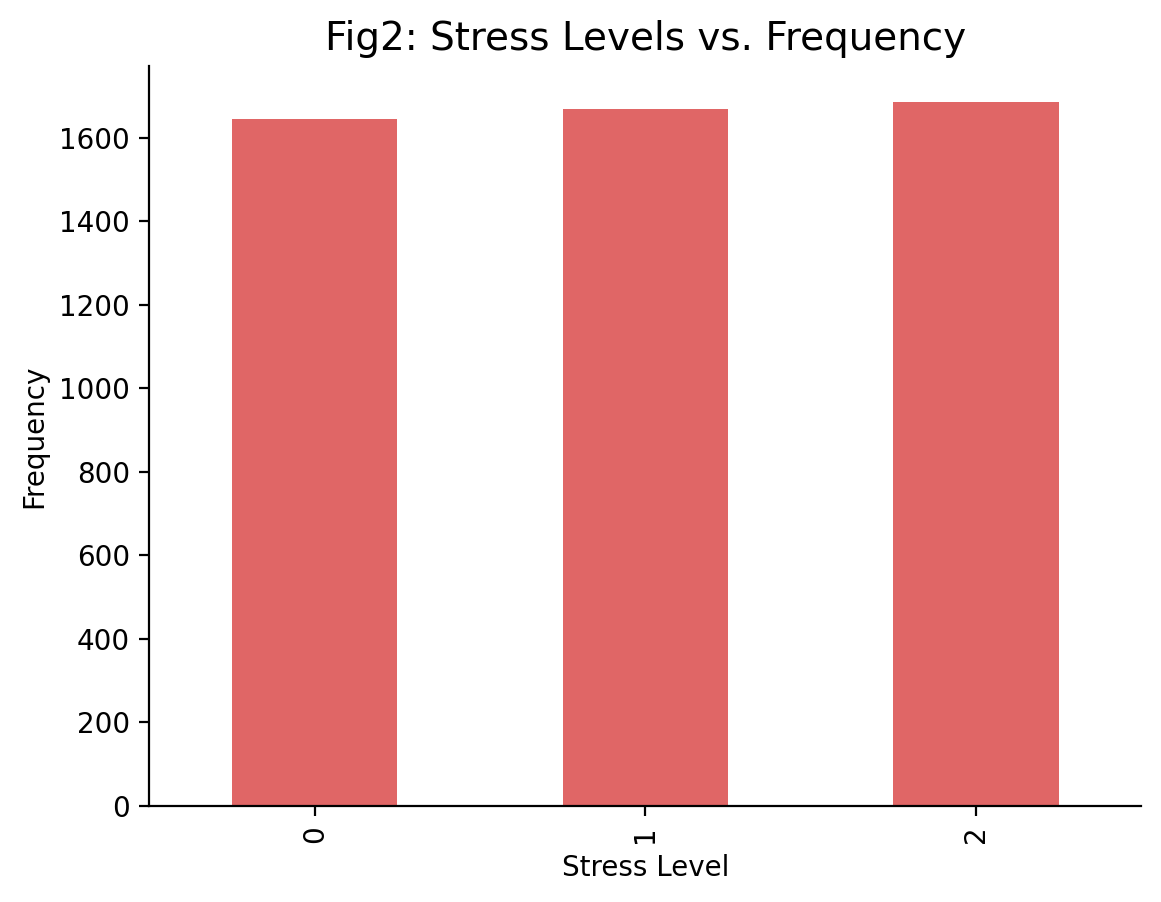

In [ ]:
#Frequency of stresses form original dataset
ax = pd.Series(S).value_counts().sort_index().plot(kind="bar", color="#e06666")
plt.title('Fig2: Stress Levels vs. Frequency', fontsize=14)
ax.set_xlabel("Stress Level")
ax.set_ylabel("Frequency");
sns.despine();

### **Prior Predictive Simulation**

According to a research article (https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2022.928928/full), more working hours caused higher levels of depression and occupational stress. The priors used in the statistical model are designed to reflect reasonable uncertainty and incorporate domain knowledge where available. For the cutpoints (α or alpha) separating the stress levels, a prior of 𝒩(1, 0.5) is selected to reflect a central tendency around 1, aligning with the expected ordinal structure of stress categories. The prior for the slope term (bH​), representing the effect of hours worked on stress levels, is chosen as 𝒩(0.025, 0.025). This reflects an assumption of small, positive effects based on prior research about the relationship between hours worked and stress. While prior predictive simulations could further validate these choices, these priors represent a balance between flexibility and the incorporation of domain knowledge.




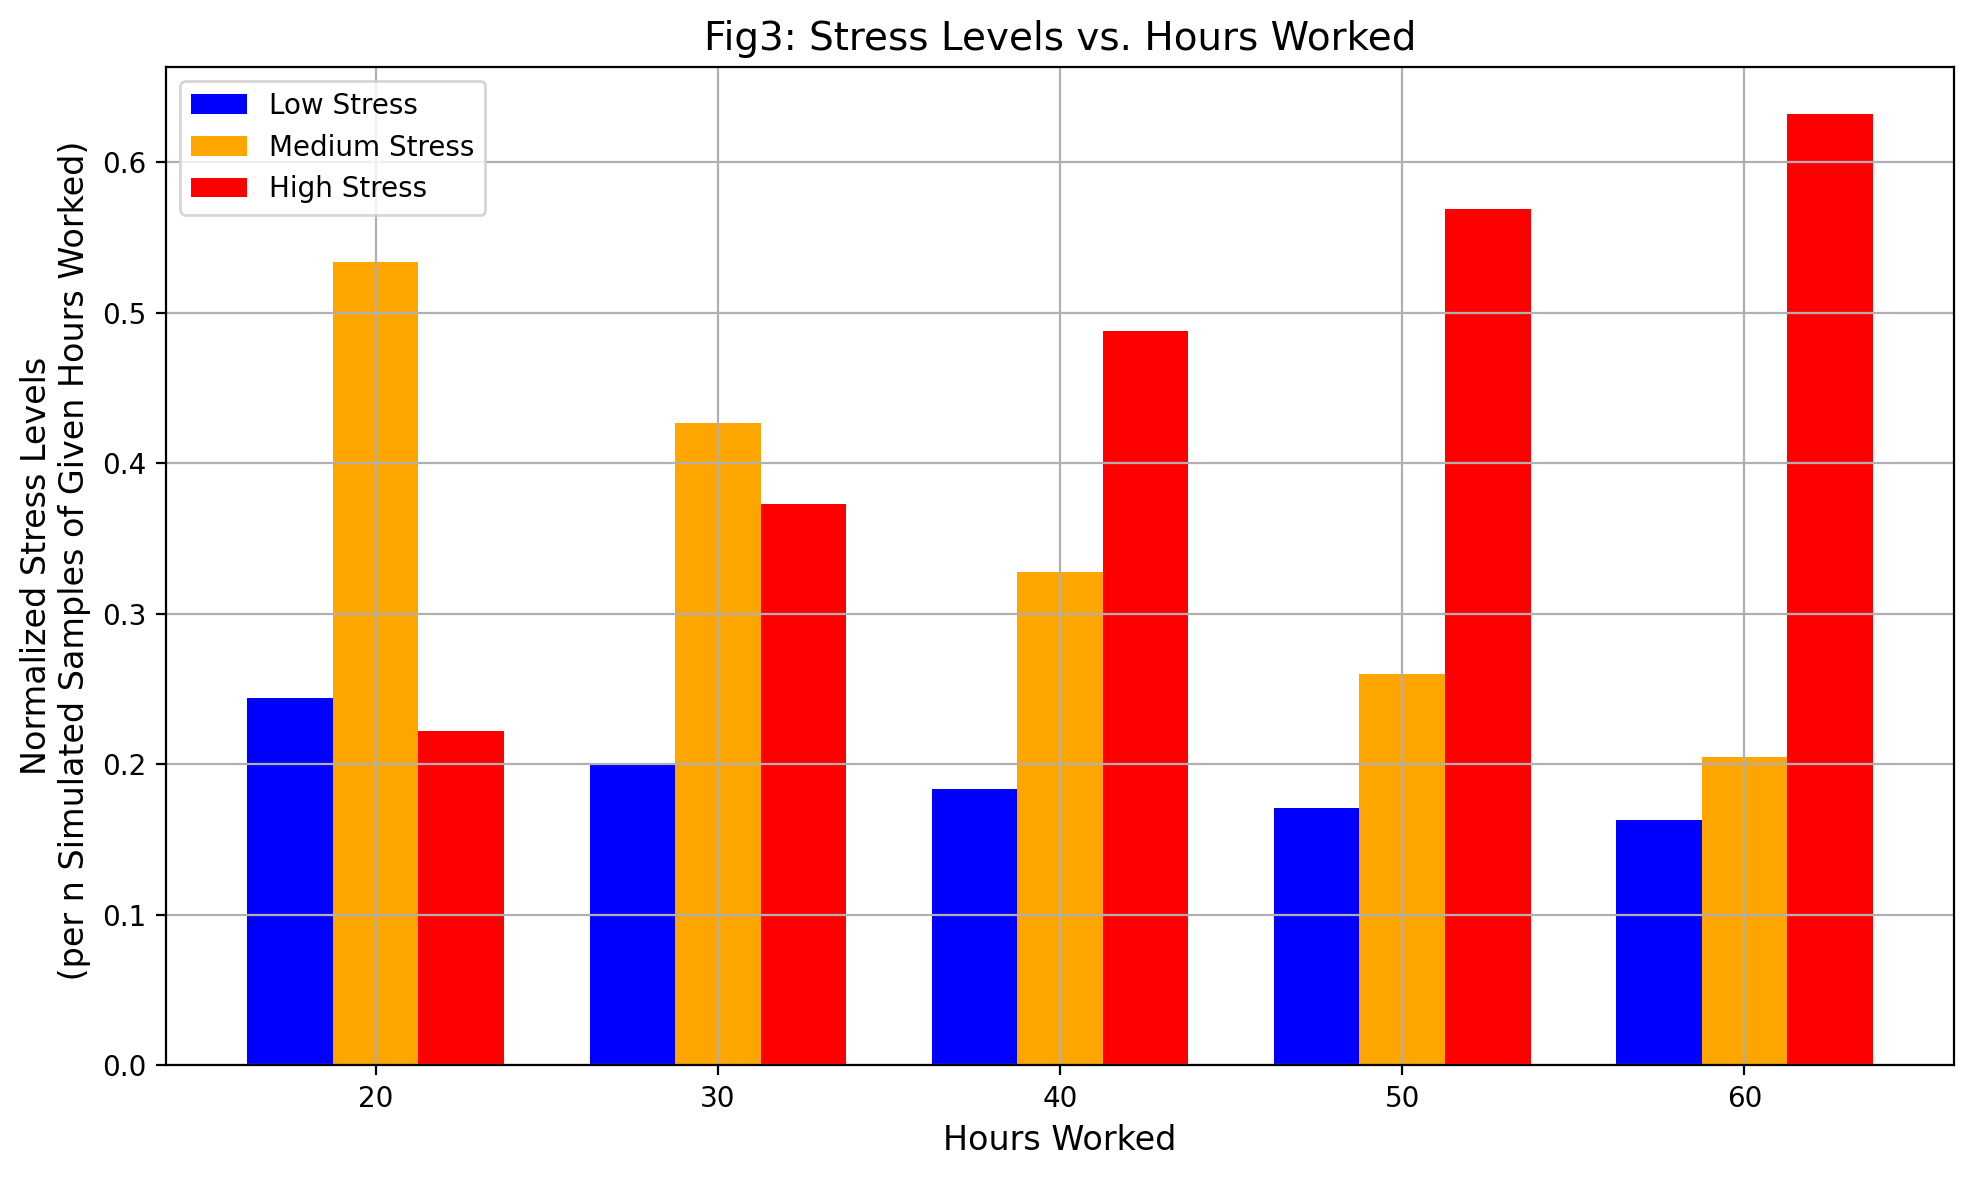

In [ ]:
# prior predictive simulation
n = 1000

# priors
alpha = stats.norm.rvs(1,0.5, size=n)
beta = stats.norm.rvs(0.025, 0.025, size=n)
hours = [20,30,40,50,60]
ys = {}
y = {}

for i in range(n):
  y = {}
  for h in hours:
    y[h] = alpha[i] + beta[i] * h
  ys[i] = y

stress_low = []
stress_med = []
stress_high = []

for h in hours:
  low = 0
  med = 0
  high = 0
  for x in ys.values():
    value = x[h]
    if value <= 1:
      low += 1
    elif value > 1 and value <=2:
      med += 1
    else:
      high += 1
  stress_low.append(low)
  stress_med.append(med)
  stress_high.append(high)

hours_stress_low = {
    'hours' : np.array(hours),
    'stress' : np.array(stress_low)/1000
}

hours_stress_med = {
    'hours' : np.array(hours),
    'stress' : np.array(stress_med)/1000
}

hours_stress_high = {
    'hours' : np.array(hours),
    'stress' : np.array(stress_high)/1000
}

bar_width = 0.25
# positions of the bars on the x-axis
# this is the x positions for each hour value
x_pos = np.arange(len(hours))

# figure and axis
plt.figure(figsize=(10, 6))

# create bars for low, medium, and high stress levels
plt.bar(x_pos - bar_width, hours_stress_low['stress'], width=bar_width, label='Low Stress', color='blue')
plt.bar(x_pos, hours_stress_med['stress'], width=bar_width, label='Medium Stress', color='orange')
plt.bar(x_pos + bar_width, hours_stress_high['stress'], width=bar_width, label='High Stress', color='red')

# titles and labels
plt.title('Fig3: Stress Levels vs. Hours Worked', fontsize=14)
plt.xlabel('Hours Worked', fontsize=12)
plt.ylabel('Normalized Stress Levels\n (per n Simulated Samples of Given Hours Worked)', fontsize=12)


# set the x-axis ticks to be at the center of the bars
plt.xticks(x_pos, hours)

# legend
plt.legend()

# add grid for easier reading
plt.grid(True)

# show the plot
plt.tight_layout()
plt.show()

# this is the key for what each stress level is encoded by
# x<=1 -> Low
# 1<x<=2 -> Medium
# 2<x -> High

The bar plots from the prior simulation represents the research results that extended working hours leads to increased stress.

**Prior predictive simulation for work location as confound**

Based on our prior research, we decided that the work location prior will have to be used in a negative sense because studies have shown that work location when moved to remote, has a negative effect on mental health, and stress levels of employees. Also, it will be negative because we decided when encoding the Work_Location variable, that Remote = 2 and Onsite = 0, so we need the inverse effect to reflect. From a US Chambers publication, we saw that, “when asked if remote work has had a negative impact on their employees’ mental health, 64% of executives said that it was anywhere from a minor to a major issue, up from 55% a year ago. The impact was more pronounced in the smaller end of the middle market, with 65% now reporting that mental health was an issue, compared to 42% a year ago.” (https://www.uschamber.com/workforce/u-s-chamber-and-rsm-survey-reveals-pandemic-driven-work-changes-are-becoming-permanent-as-competition-for-talent-continues)


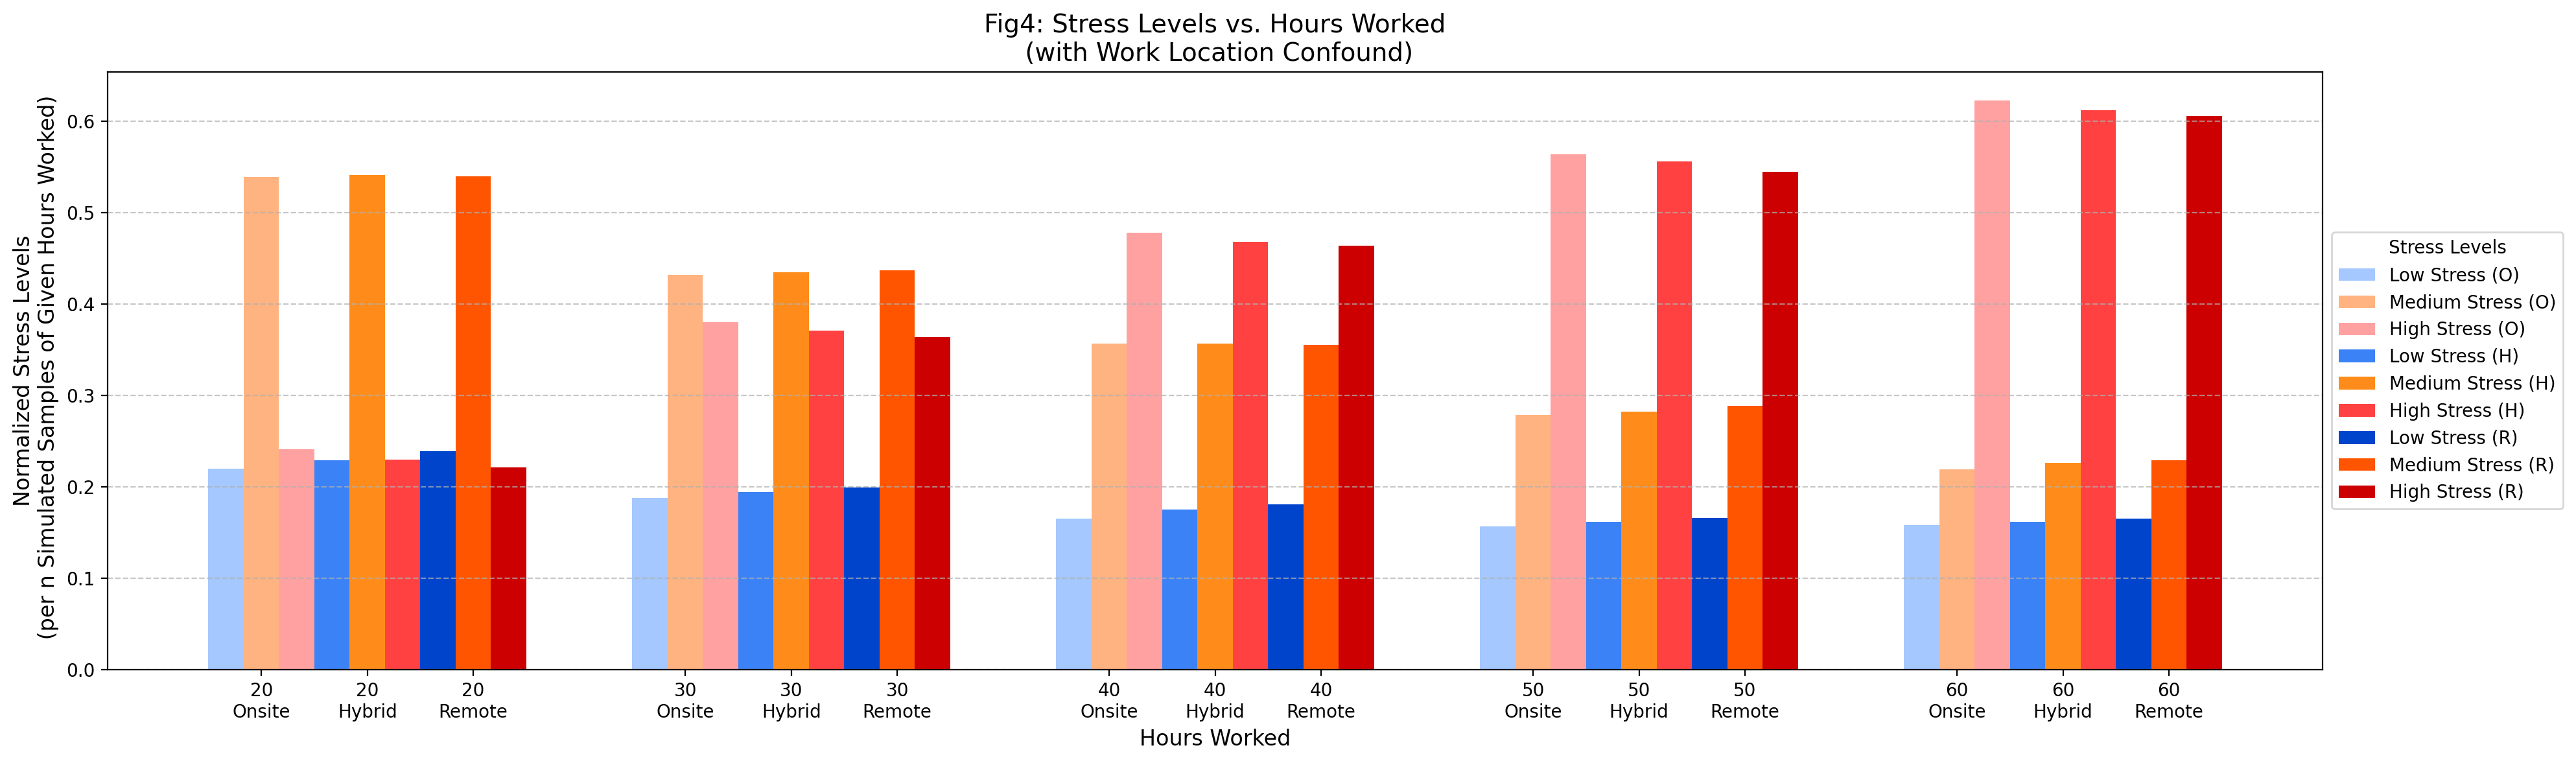

In [ ]:
# prior predictive simulation with confounds
n = 1000

# priors
alpha = stats.norm.rvs(1,0.5, size=n)
betaH = stats.norm.rvs(0.025, 0.025, size=n)
betaR = stats.norm.rvs(0.025,0.025, size = n)
hours = [20,30,40,50,60]

stress_low_O = {
    20:0,
    30:0,
    40:0,
    50:0,
    60:0
}
stress_med_O = stress_low_O.copy()
stress_high_O = stress_low_O.copy()

stress_low_H = stress_low_O.copy()
stress_med_H = stress_low_O.copy()
stress_high_H = stress_low_O.copy()

stress_low_R = stress_low_O.copy()
stress_med_R = stress_low_O.copy()
stress_high_R = stress_low_O.copy()

for i in range(n):
  # y = {}
  for h in hours:
    for r in range(3):
      value = alpha[i] + betaH[i] * h - betaR[i] * r
      if r == 0:
        if value <= 1:
          stress_low_O[h] = stress_low_O.get(h,0)+1
        elif value > 1 and value <= 2:
          stress_med_O[h] = stress_med_O.get(h,0)+1
        else:# value > 2:
          stress_high_O[h] = stress_high_O.get(h,0)+1
      elif r == 1:
        if value <= 1:
          stress_low_H[h] = stress_low_H.get(h,0)+1
        elif value > 1 and value <= 2:
          stress_med_H[h] = stress_med_H.get(h,0)+1
        else:# value > 2:
          stress_high_H[h] = stress_high_H.get(h,0)+1
      elif r == 2:
        if value <= 1:
          stress_low_R[h] = stress_low_R.get(h,0)+1
        elif value > 1 and value <= 2:
          stress_med_R[h] = stress_med_R.get(h,0)+1
        else:# value > 2:
          stress_high_R[h] = stress_high_R.get(h,0)+1

hours_stress_low_O = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_low_O.values())]
}

hours_stress_med_O = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_med_O.values())]
}

hours_stress_high_O = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_high_O.values())]
}

hours_stress_low_H = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_low_H.values())]
}

hours_stress_med_H = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_med_H.values())]
}

hours_stress_high_H = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_high_H.values())]
}

hours_stress_low_R = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_low_R.values())]
}

hours_stress_med_R = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_med_R.values())]
}

hours_stress_high_R = {
    'hours' : np.array(hours),
    'stress' : [x/n for x in list(stress_high_R.values())]
}

bar_width = 0.25
# positions of the bars on the x-axis
# this is the x positions for each hour value
x_pos = np.arange(len(hours))*3

# figure and axis
plt.figure(figsize=(20, 6))

#Add Color Gradients for Stress Levels
blues = ["#A4C8FF", "#3B82F6", "#0044CC"]
oranges = ["#FFB380", "#FF8C1A", "#FF5500"]
reds = ["#FFA1A1", "#FF4141", "#CC0000"]

# Create bars for low, medium, and high stress levels
plt.bar(x_pos - 4 * bar_width, hours_stress_low_O['stress'], width=bar_width, label='Low Stress (O)', color=blues[0])
plt.bar(x_pos - 3* bar_width, hours_stress_med_O['stress'], width=bar_width, label='Medium Stress (O)', color=oranges[0])
plt.bar(x_pos - 2 * bar_width, hours_stress_high_O['stress'], width=bar_width, label='High Stress (O)', color=reds[0])

plt.bar(x_pos - bar_width, hours_stress_low_H['stress'], width=bar_width, label='Low Stress (H)', color=blues[1])
plt.bar(x_pos, hours_stress_med_H['stress'], width=bar_width, label='Medium Stress (H)', color=oranges[1])
plt.bar(x_pos +  bar_width, hours_stress_high_H['stress'], width=bar_width, label='High Stress (H)', color=reds[1])

plt.bar(x_pos + 2* bar_width, hours_stress_low_R['stress'], width=bar_width, label='Low Stress (R)', color=blues[2])
plt.bar(x_pos + 3 * bar_width, hours_stress_med_R['stress'], width=bar_width, label='Medium Stress (R)', color=oranges[2])
plt.bar(x_pos + 4 * bar_width, hours_stress_high_R['stress'], width=bar_width, label='High Stress (R)', color=reds[2])

# titles and labels
plt.title('Fig4: Stress Levels vs. Hours Worked\n (with Work Location Confound)', fontsize=14)
plt.xlabel('Hours Worked', fontsize=12)
plt.ylabel('Normalized Stress Levels\n (per n Simulated Samples of Given Hours Worked)', fontsize=12)

# Set the x-axis ticks to be at the center of the bars
x_labels = []
for hour in hours:
    x_labels.extend([f'{hour}\nOnsite', f'{hour}\nHybrid', f'{hour}\nRemote'])
grouped_x_pos = np.ravel([[x - bar_width * 3, x, x + bar_width * 3] for x in x_pos])

# Set the x-axis ticks and labels
plt.xticks(grouped_x_pos, x_labels, fontsize=10)

# legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stress Levels', fontsize=10)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)


# show the plot
plt.tight_layout()
plt.show()

# this is the key for what each stress level is encoded by
# x<=1 -> Low
# 1<x<=2 -> Medium
# 2<x -> High

In [ ]:
RANDOM_SEED = 8927
np.random.seed(365)

Causal Model:

This project aims to quantify the causal effect of hours worked per week (H) on stress levels (S) while adjusting for work location (W) as a confounding variable. Hours worked per week is treated as the treatment variable, stress levels are the outcome, and work location serves as the confound. By incorporating work location into the model, the study seeks to disentangle its dual influence on both hours worked and stress levels, ensuring a more accurate estimation of the causal effect. This causal framework is crucial for understanding how varying work environments impact employee well-being, especially given the rise of remote and hybrid work arrangements.

The assumed relationships in this model are as follows: Hours worked per week (H) is hypothesized to have a direct causal effect on stress levels (S), as longer working hours are often associated with higher stress. Work location (W) is a confounding variable because it simultaneously influences the number of hours worked and stress levels. For example, individuals working remotely (W) may have more flexible schedules, which could reduce stress (S), but they may also work longer hours (H), potentially increasing stress. These relationships reflect the real-world complexity of how stress levels are influenced by both working hours and the environment in which work takes place.

Directed Acyclic Graph (DAG)
The DAG captures the causal relationships between the treatment, outcome, and confound variables. The variables in the causal model are clearly labeled as follows:
H (Hours worked per week) as the Treatment
S (Stress levels) as the Outcome
W (Work location: Remote, Hybrid, Onsite) as the Confound

The DAG visually represents these interactions, with arrows showing that work location (W) influences both hours worked (H) and stress levels (S), and hours worked (H) directly influences stress levels (S). This structured representation helps clarify the assumed causal pathways and supports the design of the statistical model.


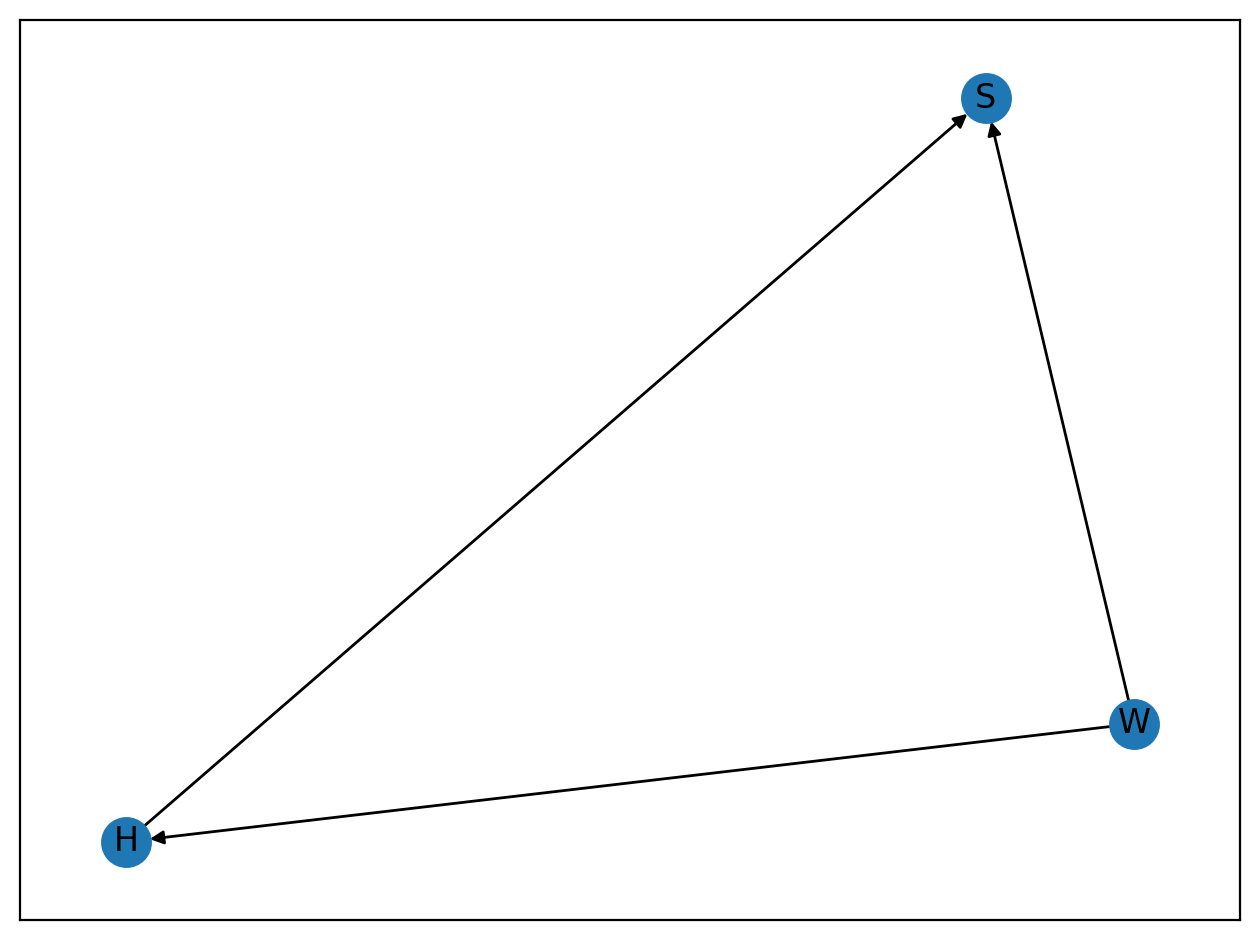

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("W", "S"), ("W","H"), ("H","S")])

nx.draw_networkx(graph, arrows=True)
plt.tight_layout()

### **Statistical model that estimates the total causal effect of hours worked on stress levels, without accounting for the potential confound of work location.**

The statistical model for the total causal effect of hours worked (H) on stress levels (S) is described using the following equations:<br>**Ordered Logit:**


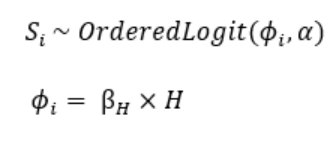


Where:    
α / alpha: Represents the cutpoints separating stress categories.  
Si​​: Represents stress level for the sample i.  
bH​​: Represents the effect of hours worked on stress.  
H: Represents the observed values for hours worked from the dataset.
  
  
  **Log Odds function:**


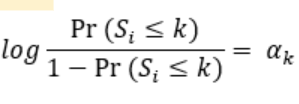

In [ ]:
# predict stress level based on hours worked (no confounds)
S = df.stress_new.values
H = df["Hours_Worked_Per_Week"]

with pm.Model() as mHS:
    # cutpoints
    alpha = pm.Normal(
        name="alpha",
        mu=1,
        sigma=0.5,
        # shape = 2 because there are 3 categories
        shape = 2
    )

    b = pm.Normal(name = "b",mu = 0.025,sigma = 0.025)

    HW = pm.MutableData("HW", H.values)

    phi = pm.Deterministic("phi", b * HW)

    stress_levels = pm.OrderedLogistic("stress_levels", phi, cutpoints = alpha, observed=S)

    idata_HS = pm.sample(random_seed=RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Output()

In [ ]:
az.summary(idata_HS, var_names = ["alpha","b"], round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.547063,0.089399,-0.703719,-0.368505,0.004963,0.003605,326.024842,389.592211,1.000208
alpha[1],0.839732,0.089980,0.679422,1.016666,0.004935,0.003493,330.114697,385.392320,1.001285
b,0.004034,0.002141,0.000080,0.008246,0.000117,0.000083,334.649036,363.963324,1.000388


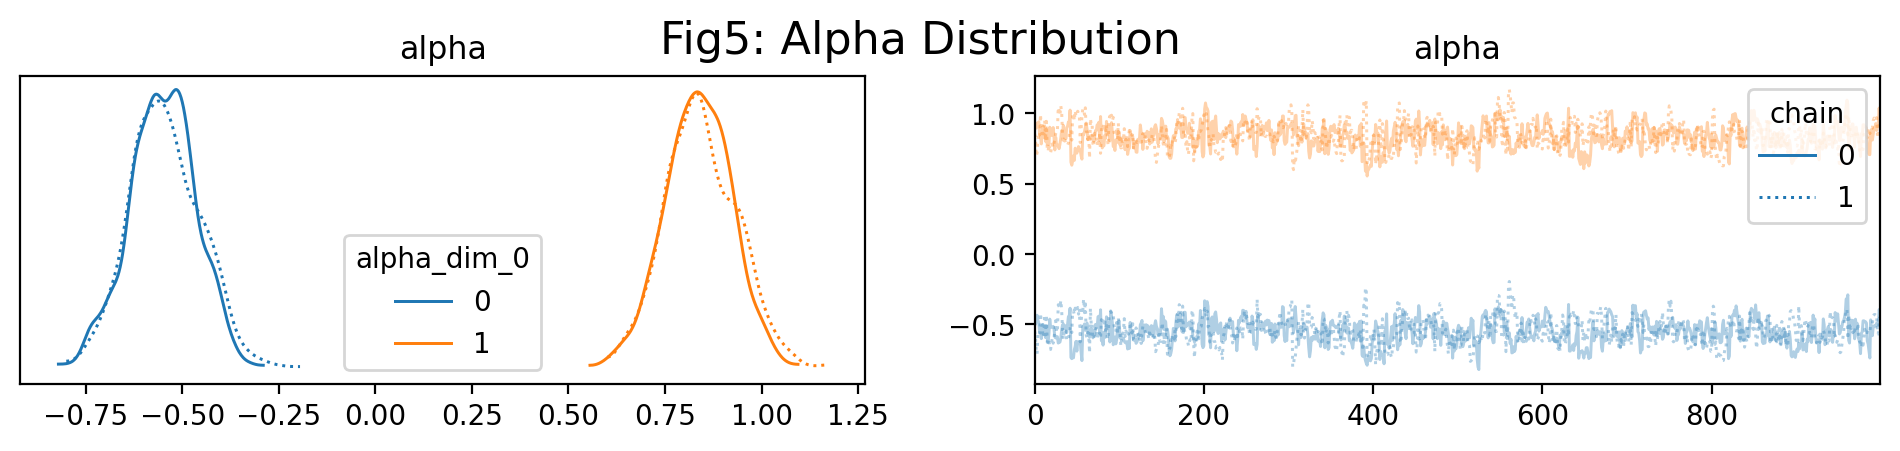

In [ ]:
az.plot_trace(idata_HS, var_names = ["alpha"], compact=True, legend=True)
plt.suptitle("Fig5: Alpha Distribution", fontsize=16, y=1.02)  # Adjust y for spacing
plt.show()

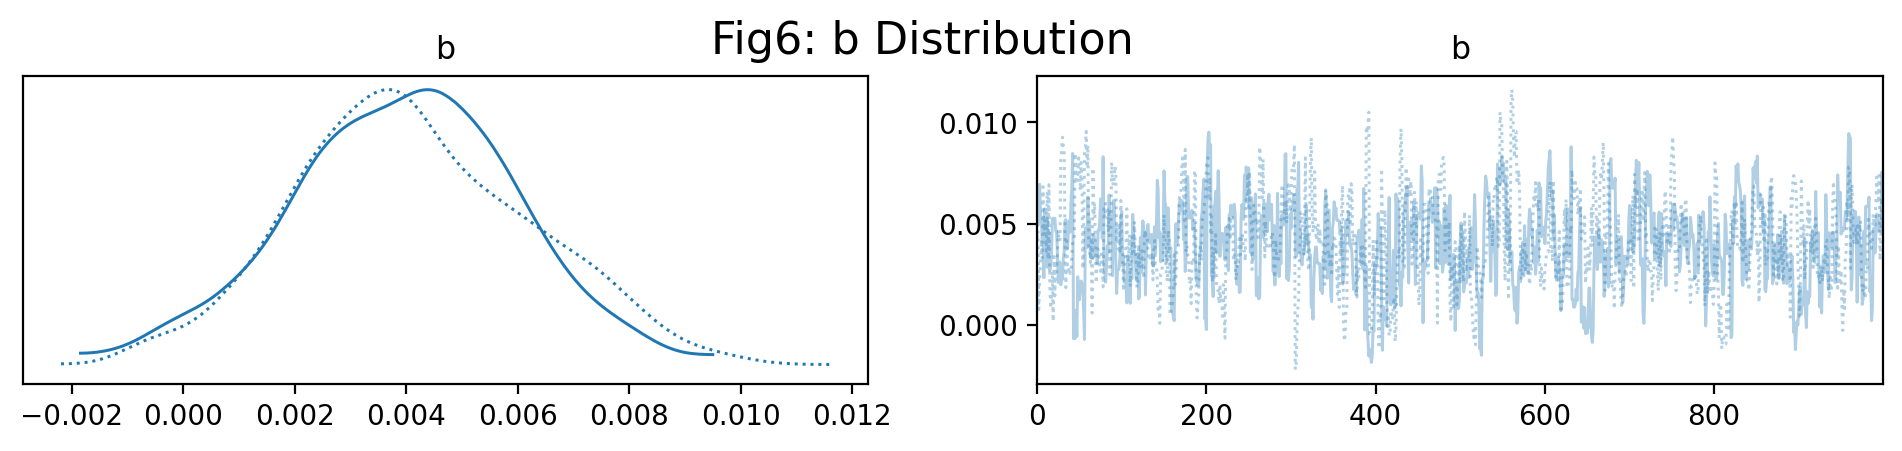

In [ ]:
az.plot_trace(idata_HS, var_names = ["b"], compact=True)
plt.suptitle("Fig6: b Distribution", fontsize=16, y=1.02)  # Adjust y for spacing
plt.show()

The model generated to realize the total causal effect of hours worked (H) on stress level (S) has a mean value of approximately 0.004034 for the slope. In the context of the model this means that, on average, with each hour worked the stress level increases by 0.004034 per hour. The trace plot for b shows that the relational factor is reliably positive. From this we can say that it is probable that the relationship between hours worked and stress level is positive (i.e., a person who works more hours is more likely to have higher stress levels.) The mean value of b seems small, but one must consider that the values for hours worked range from 20 to 60 while the stress levels are an element of {0,1,2} in the observed data. Therefore, to map hours worked to stress level, the b must be sufficiently small. The rhat values for each of these parameter values is very close to 1 suggesting that these parameter values are likely an accurate representation of the relationship between hours worked and stress level. In conclusion, from the parameter values from the model, the total causal effect of hours worked on stress level has a small but reliably positive correlation.


In [ ]:
with mHS:
    post_pred = pm.sample_posterior_predictive(
                    idata_HS,
                    var_names=["HW","stress_levels"],
                    random_seed=RANDOM_SEED
    )


pp_stress = az.extract(post_pred, group="posterior_predictive")["stress_levels"]

Output()

In [ ]:
def map_hour_value(h):
    if h < 25:
        return 20
    elif 25 <= h < 35:
        return 30
    elif 35 <= h < 45:
        return 40
    elif 45 <= h < 55:
        return 50
    elif 55 <= h < 65:
        return 60
    return h  # Return the original value if no condition is met

In [ ]:
pp_H = az.extract(post_pred, group = "posterior_predictive")["HW"]
predicted_stress = pp_stress[:,:10].values.flatten()
predicted_hours = pp_H[:,:10].values.flatten()

predicted = {
    'work_hours':predicted_hours,
    'stress_level':predicted_stress
}
predicted['work_hours'] = np.vectorize(map_hour_value)(predicted['work_hours'])
hours = [20,30,40,50,60]
predicted = pd.DataFrame(predicted)
hours_sum  = [np.sum(predicted['work_hours']== hour) for hour in hours]

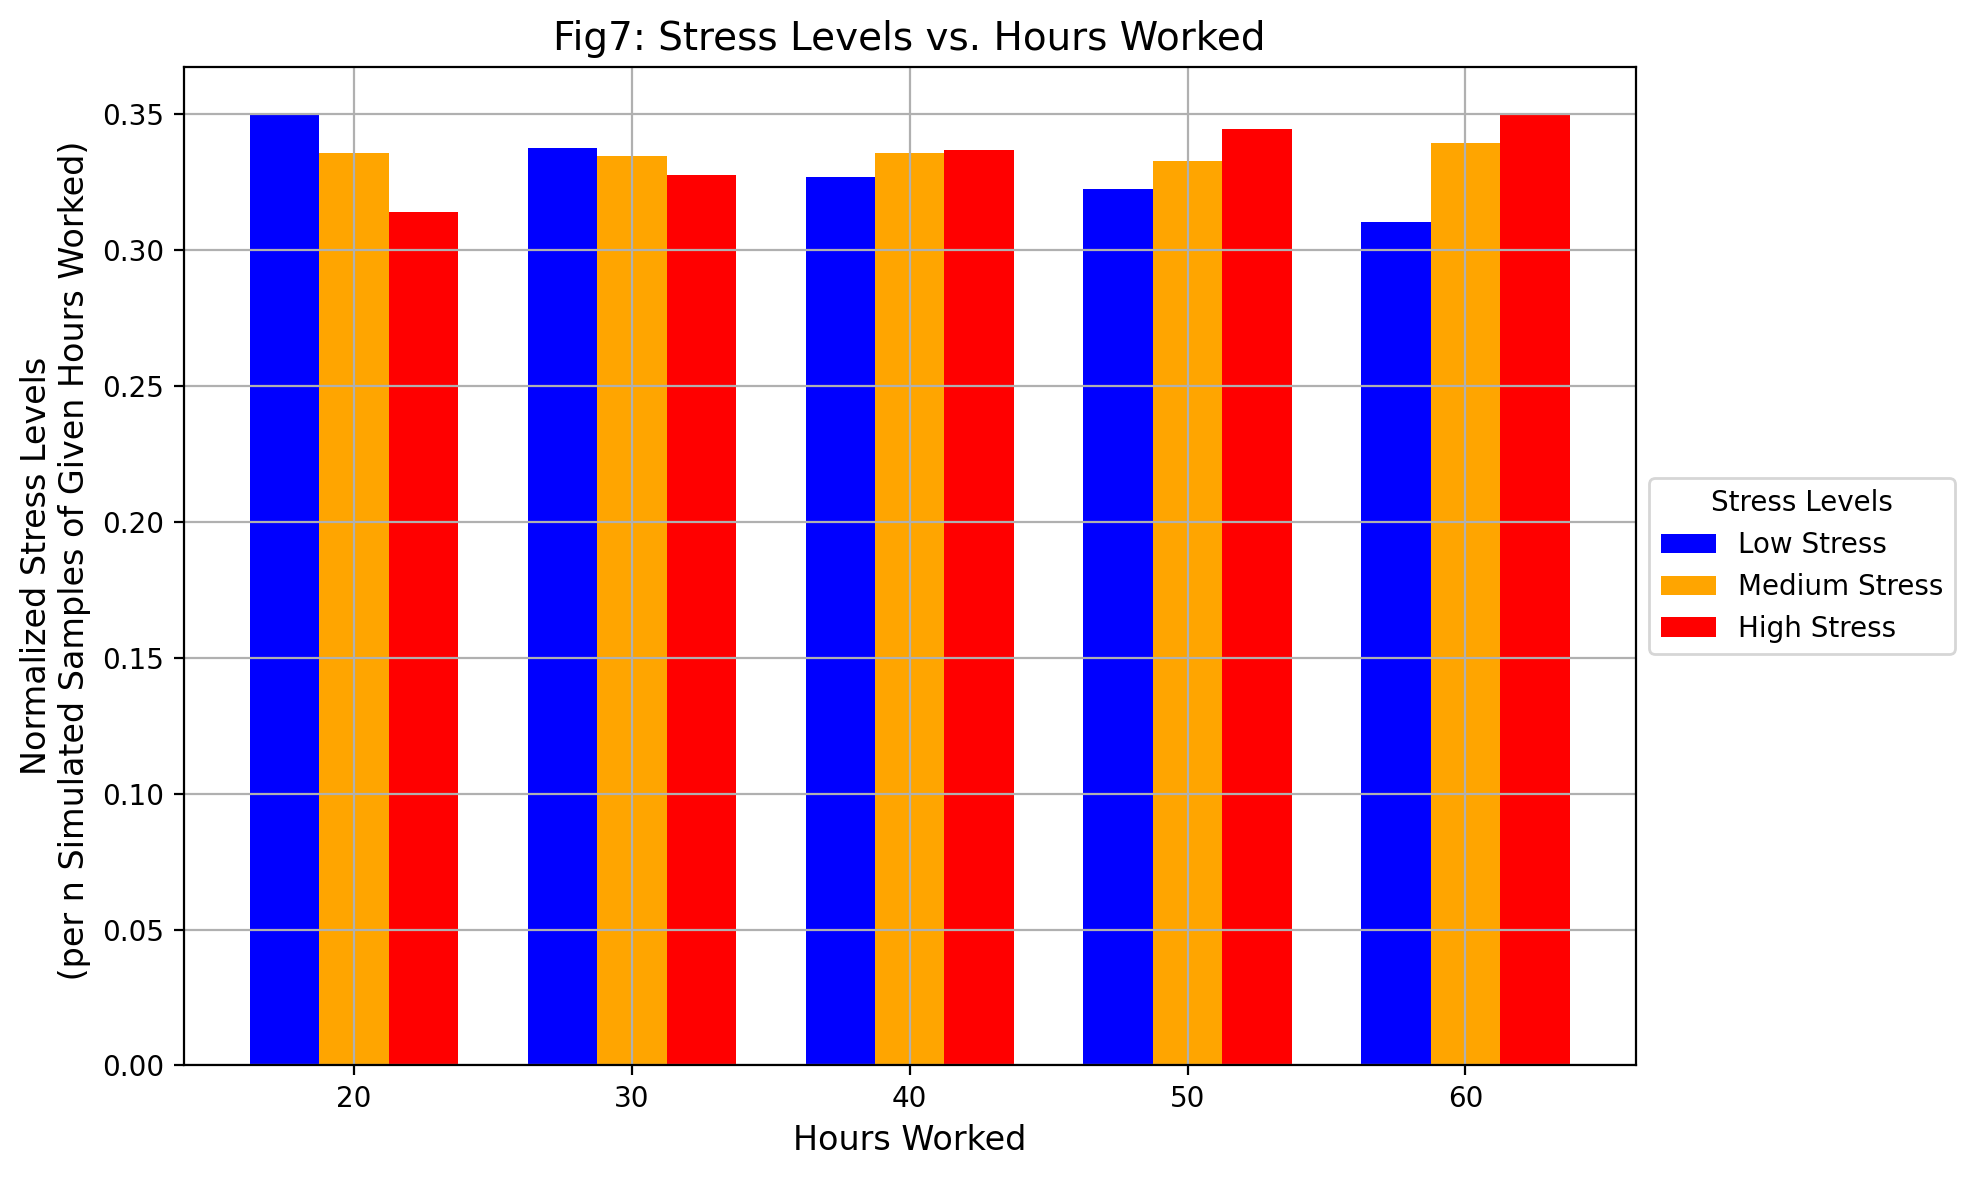

In [ ]:
#Posterior with No Confounds
stress_low_total = {
    20:0,
    30:0,
    40:0,
    50:0,
    60:0
}
stress_med_total = stress_low_total.copy()
stress_high_total = stress_low_total.copy()

for i,h in enumerate(predicted_hours):
  if h < 25:
    hour_val = 20
  elif h >= 25 and h < 35:
    hour_val = 30
  elif h >= 35 and h < 45:
    hour_val = 40
  elif h >= 45 and h < 55:
    hour_val = 50
  elif h >=55 and h < 65:
    hour_val = 60
  else:
    hour_val = 100
  s = predicted_stress[i]
  if s == 0:
    stress_low_total[hour_val] = stress_low_total.get(hour_val,0) + 1
  elif s == 1:
    stress_med_total[hour_val] = stress_med_total.get(hour_val,0) + 1
  elif s == 2:
    stress_high_total[hour_val] = stress_high_total.get(hour_val,0) + 1


hours_stress_low = {
    'hours': list(stress_low_total.keys()),
    'stress': [a/b for a,b in zip(list(stress_low_total.values()),hours_sum)]
}

hours_stress_med = {
    'hours': list(stress_med_total.keys()),
    'stress': [a/b for a,b in zip(list(stress_med_total.values()),hours_sum)]
}

hours_stress_high = {
    'hours': list(stress_high_total.keys()),
    'stress': [a/b for a,b in zip(list(stress_high_total.values()),hours_sum)]
}

bar_width = 0.25

# positions of the bars on the x-axis
# the x positions for each hour value
x_pos = np.arange(len(hours))

# create the figure and axis
plt.figure(figsize=(10, 6))

# create bars for low, medium, and high stress levels
plt.bar(x_pos - bar_width, hours_stress_low['stress'], width=bar_width, label='Low Stress', color='blue')
plt.bar(x_pos, hours_stress_med['stress'], width=bar_width, label='Medium Stress', color='orange')
plt.bar(x_pos + bar_width, hours_stress_high['stress'], width=bar_width, label='High Stress', color='red')

#  titles and labels
plt.title('Fig7: Stress Levels vs. Hours Worked', fontsize=14)
plt.xlabel('Hours Worked', fontsize=12)
plt.ylabel('Normalized Stress Levels\n (per n Simulated Samples of Given Hours Worked)', fontsize=12)

# set the x-axis ticks to be at the center of the bars
plt.xticks(x_pos, hours)

# legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stress Levels', fontsize=10)

# add grid
plt.grid(True)

# show the plot
plt.tight_layout()
plt.show()

Figure 7 illustrates the small but positive correlation between hours worked and stress level. The bar chart depicts the proportion of samples with each of the stress levels normalized to the number of samples for the respective hours (i.e., for low stress level at 20 hours, the value is calculated by dividing the number of samples that had a low stress level at 20 hours by the total number of samples that were at 20 hours.) This normalization allows the differences in proportions to be highlighted while plotting the total number of samples would dampen the perceived effect of number of hours on stress level if, for example, significantly more samples worked 30 hours than 20 hours. One can see from the plot that as more hours are worked the proportion of low stress levels decreases and the proportion of high stress levels increases slightly.

In [ ]:
df["work_new"] = pd.Categorical(
    df.Work_Location.values,
    categories=[
        "Onsite",
        "Hybrid",
        "Remote"
    ],
    ordered=False,
)
df["work_new"] = df.work_new.cat.codes

##  Stastical model that estimates the causal effect of hours worked on stress levels while accounting for the confounding factor of work location.

The statistical model for the direct causal effect of hours worked (H) on stress levels (S) as well as the direct causal effect of work location (R) on stress levels is described using the following equations:

**Order Logit Predictor:**

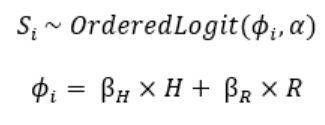

α / alpha: Represents the cutpoints separating stress categories.<br>
Si​​: Represents stress level for the sample i.<br>
bH​​: Represents the effect of hours worked on stress.<br>
H: Represents the observed values for hours worked from the dataset.<br>
bR​​: Represents the effects for work location.<br>
R: Represents the observed values for work location from the dataset.

**Log Odds Function:**

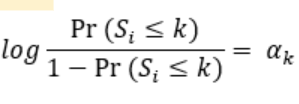

In [ ]:
# predict stress level based on hours worked with the confound of work location
S = df.stress_new.values
H = df["Hours_Worked_Per_Week"]
W = df["work_new"]

with pm.Model() as mHSL:
    # cutpoints
    alpha = pm.Normal(
        name="alpha",
        mu=1,
        sigma=0.5,
        shape = 2
    )
    b = pm.Normal(name = "b",mu = 0.025, sigma = 0.025, shape = 3)

    HW = pm.MutableData("HW", H.values)

    WL = pm.MutableData("WL",W.values)

    phi = pm.Deterministic("phi", b[WL] * HW)

    stress_levels = pm.OrderedLogistic("stress_levels", phi, cutpoints = alpha, observed=S)

    idata_HSL = pm.sample(random_seed=RANDOM_SEED)

/usr/local/lib/python3.10/dist-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Output()

In [ ]:
az.summary(idata_HSL, var_names = ["alpha","b"], round_to=6)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.542210,0.084630,-0.697009,-0.390818,0.004303,0.003045,384.190536,666.921778,1.005594
alpha[1],0.846353,0.084401,0.692168,0.995702,0.004395,0.003131,367.306051,667.810587,1.003396
b[0],0.003203,0.002206,-0.000674,0.007384,0.000108,0.000079,417.929326,658.798675,1.001416
b[1],0.004382,0.002187,0.000322,0.008370,0.000107,0.000076,418.950989,755.099473,1.000806
b[2],0.004942,0.002173,0.000945,0.008905,0.000106,0.000077,413.893113,682.411115,1.002585


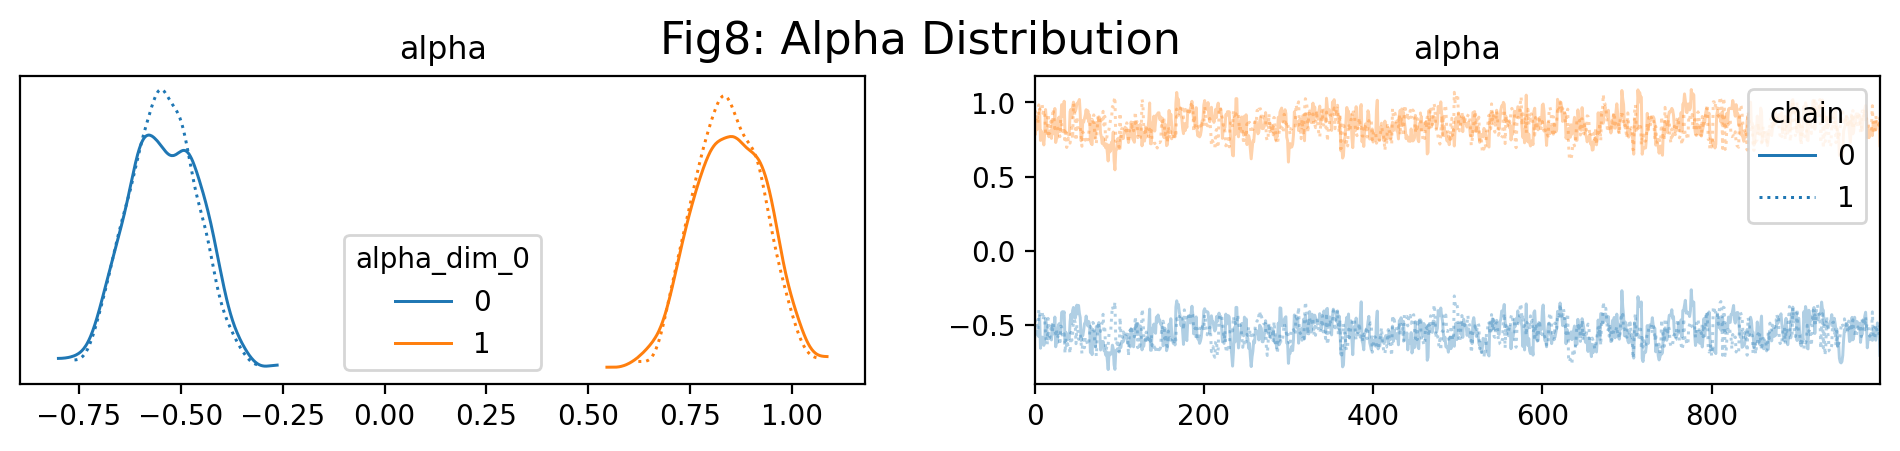

In [ ]:
az.plot_trace(idata_HSL, var_names = ["alpha"], compact=True, legend=True)
plt.suptitle("Fig8: Alpha Distribution", fontsize=16, y=1.02)  # Adjust y for spacing
plt.show()

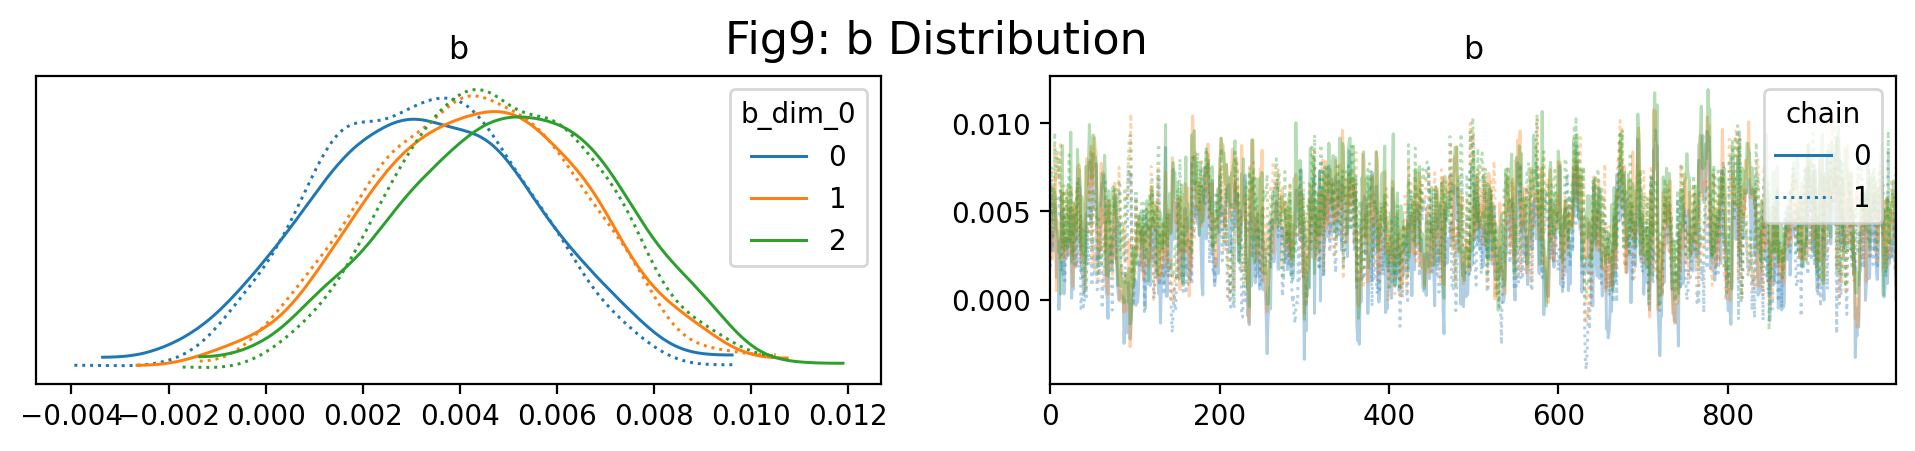

In [ ]:
az.plot_trace(idata_HSL, var_names = ["b"], compact=True, legend=True)
plt.suptitle("Fig9: b Distribution", fontsize=16, y=1.02)  # Adjust y for spacing
plt.show()

The model generated to realize the direct causal effect of hours worked (H) on stress level (S) with work location(W) as a confound has a mean value of 0.003203 for Onsite work, a mean value of 0.004382 for Hybrid work, and a mean value of 0.004942 for Remote work. In the context of the model this means that, on average with each hour worked the stress level increases by these b values for the corresponding work location. The trace plot for each of the b values shows that all of the relational factors are reliably positive. This means that for every work location, the direct effect of hours worked on stress level is probably positive. Similar to the model for the total causal effect of hours worked on stress level, one must consider that the values for hours worked range from 20 to 60 while the stress levels are an element of {0,1,2} in the observed data. Therefore, to map hours worked to stress level, the b must be sufficiently small. The b value for Onsite work (b[0]) is smaller than the b value for Hybrid work (b[1]) which is smaller the b value for Remote work (b[2]). This suggests that the effect of hours worked on stress levels is greater for Remote work than Hybrid work which is greater than for Onsite work. Finally, the rhat values for each of these parameter values is very close to 1 suggesting that these parameter values are likely an accurate representation of the relationship between hours worked and stress level.


In [ ]:
with mHSL:
    post_pred2 = pm.sample_posterior_predictive(
                    idata_HSL,
                    var_names=["HW","stress_levels","WL"],
                    random_seed=RANDOM_SEED
    )

Output()

In [ ]:
pp_stress2 = az.extract(post_pred2, group="posterior_predictive")["stress_levels"]
pp_H2 = az.extract(post_pred2, group = "posterior_predictive")["HW"]
pp_W2 = az.extract(post_pred2, group = "posterior_predictive")["WL"]
predicted_stress2 = pp_stress2[:,:10].values.flatten()
predicted_hours2 = pp_H2[:,:10].values.flatten()
predicted_work2 = pp_W2[:,:10].values.flatten()
predicted_work2 = [int(value) for value in predicted_work2]

predicted2 = {
    'work_location':predicted_work2,
    'work_hours':predicted_hours2,
    'stress_level':predicted_stress2
}

predicted2 = pd.DataFrame(predicted2)

In [ ]:
predicted2['work_hours'] = predicted2['work_hours'].apply(map_hour_value)

counts = predicted2.groupby(['work_hours', 'work_location']).size()

full_combinations = pd.MultiIndex.from_product(
    [[20,30,40,50,60], [0,1,2]], names=['work_hours','work_location']
)

counts = counts.reindex(full_combinations, fill_value=0)
counts = counts.tolist()
full_combo = [[full_combinations[i], full_combinations[i + 3], full_combinations[i + 6], full_combinations[i + 9], full_combinations[i + 12]] for i in range(3)]
result = [[counts[i], counts[i + 3], counts[i + 6], counts[i + 9], counts[i + 12]] for i in range(3)]

In [ ]:
whs_totals = predicted2.groupby(['work_hours', 'work_location','stress_level']).size()

full_combinations = pd.  MultiIndex.from_product(
    [[20,30,40,50,60], [0,1,2],[0,1,2]], names=['work_hours','work_location', 'stress_level']
)
whs_totals = whs_totals.reindex(full_combinations, fill_value=0)
whs_totals = whs_totals.tolist()
fc = [[[full_combinations[i+j] , full_combinations[i+j+9] ,full_combinations[i+j+18] ,full_combinations[i+j+27] , full_combinations[i+j+36]] for i in range(3)] for j in range(0,9,3)]
wsh = [[[whs_totals[i+j] , whs_totals[i+j+9] ,whs_totals[i+j+18] ,whs_totals[i+j+27] , whs_totals[i+j+36]] for i in range(3)] for j in range(0,9,3)]
wsh_norm = [[[a / b for a,b in zip(wsh[i][j],result[i])] for  j in range(3)] for i in range(3)]

In [ ]:
column_sums = [[sum(col) for col in zip(*matrix)] for matrix in wsh_norm]

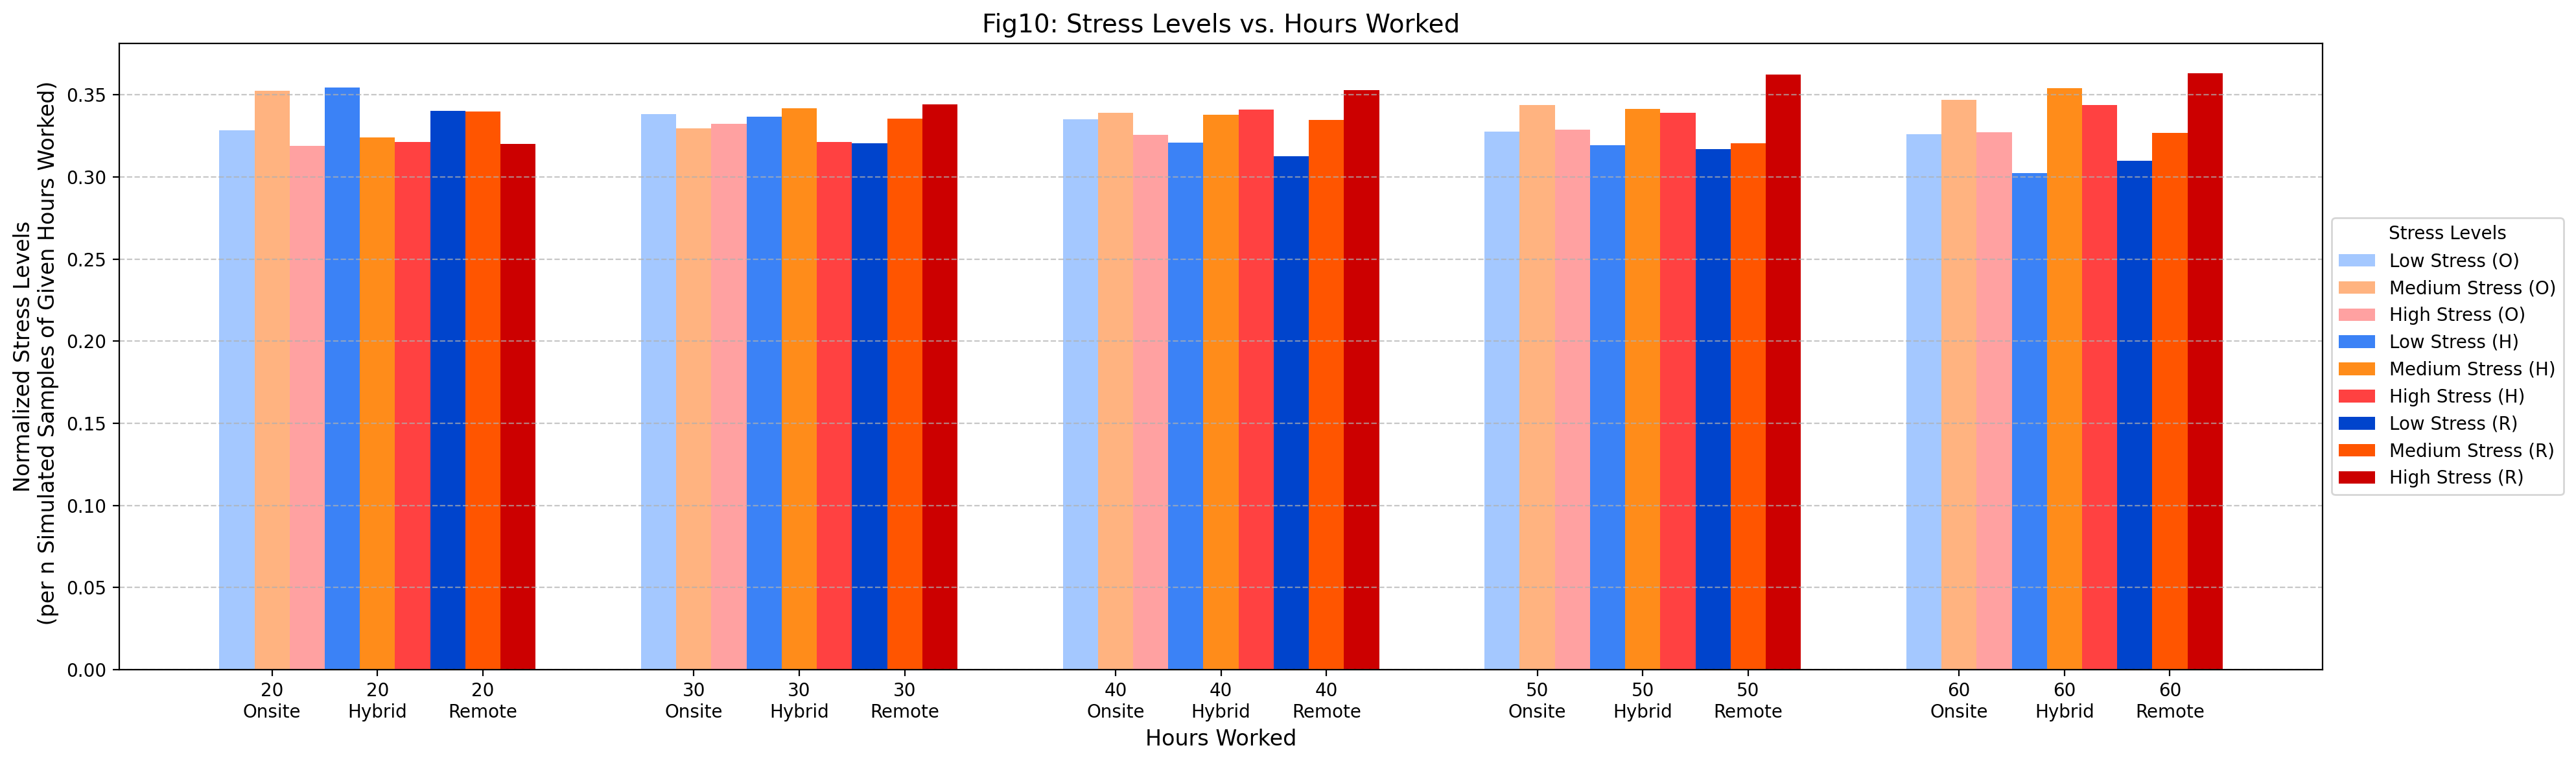

In [ ]:
hours = [20,30,40,50,60]

hours_stress_low_O = {
    'hours': hours,
    'stress': list(wsh_norm[0][0])
}

hours_stress_med_O = {
    'hours': hours,
    'stress': list(wsh_norm[0][1])
}

hours_stress_high_O = {
    'hours': hours,
    'stress': list(wsh_norm[0][2])
}

hours_stress_low_H = {
    'hours': hours,
    'stress': list(wsh_norm[1][0])
}

hours_stress_med_H = {
    'hours': hours,
    'stress': list(wsh_norm[1][1])
}

hours_stress_high_H = {
    'hours': hours,
    'stress': list(wsh_norm[1][2])
}

hours_stress_low_R = {
    'hours': hours,
    'stress': list(wsh_norm[2][0])
}

hours_stress_med_R = {
    'hours': hours,
    'stress': list(wsh_norm[2][1])
}

hours_stress_high_R = {
    'hours': hours,
    'stress': list(wsh_norm[2][2])
}

bar_width = 0.25
# Set the positions of the bars on the x-axis
x_pos = np.arange(len(hours)) * 3  # This is the x positions for each hour value

# Create the figure and axis
plt.figure(figsize=(20, 6))

#Add Color Gradients for Stress Levels
blues = ["#A4C8FF", "#3B82F6", "#0044CC"]
oranges = ["#FFB380", "#FF8C1A", "#FF5500"]
reds = ["#FFA1A1", "#FF4141", "#CC0000"]

# Create bars for low, medium, and high stress levels
plt.bar(x_pos - 4 * bar_width, hours_stress_low_O['stress'], width=bar_width, label='Low Stress (O)', color=blues[0])
plt.bar(x_pos - 3* bar_width, hours_stress_med_O['stress'], width=bar_width, label='Medium Stress (O)', color=oranges[0])
plt.bar(x_pos - 2 * bar_width, hours_stress_high_O['stress'], width=bar_width, label='High Stress (O)', color=reds[0])

plt.bar(x_pos - bar_width, hours_stress_low_H['stress'], width=bar_width, label='Low Stress (H)', color=blues[1])
plt.bar(x_pos, hours_stress_med_H['stress'], width=bar_width, label='Medium Stress (H)', color=oranges[1])
plt.bar(x_pos +  bar_width, hours_stress_high_H['stress'], width=bar_width, label='High Stress (H)', color=reds[1])

plt.bar(x_pos + 2* bar_width, hours_stress_low_R['stress'], width=bar_width, label='Low Stress (R)', color=blues[2])
plt.bar(x_pos + 3 * bar_width, hours_stress_med_R['stress'], width=bar_width, label='Medium Stress (R)', color=oranges[2])
plt.bar(x_pos + 4 * bar_width, hours_stress_high_R['stress'], width=bar_width, label='High Stress (R)', color=reds[2])

# Add titles and labels
plt.title('Fig10: Stress Levels vs. Hours Worked', fontsize=14)
plt.xlabel('Hours Worked', fontsize=12)
plt.ylabel('Normalized Stress Levels\n (per n Simulated Samples of Given Hours Worked)', fontsize=12)

# Set the x-axis ticks to be at the center of the bars
x_labels = []
for hour in hours:
    x_labels.extend([f'{hour}\nOnsite', f'{hour}\nHybrid', f'{hour}\nRemote'])
grouped_x_pos = np.ravel([[x - bar_width * 3, x, x + bar_width * 3] for x in x_pos])

# Set the x-axis ticks and labels
plt.xticks(grouped_x_pos, x_labels, fontsize=10)

#Add a Legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Stress Levels', fontsize=10)

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Outcomes:

The analysis using an Ordered Logistic Regression model reveals no significant correlation between hours worked per week and stress levels. Including work location (remote, hybrid, onsite) as a confounding variable does not alter this conclusion. There is a slightly stronger effect of hours worked on stress level for Remote workers than for Hybrid and Onsite workers. The estimated coefficients for hours worked (bH) and work location (bR) are effectively zero, indicating no measurable impact of these variables on stress levels.


The findings challenge common assumptions about the relationship between work hours and stress, suggesting that other factors not included in this dataset may play a more significant role. For instance, variables such as job demands, interpersonal relationships, or individual coping mechanisms might better explain stress levels. These results emphasize that simplistic metrics, such as hours worked or work location, are insufficient for understanding workplace stress.

Implications:

From a practical standpoint, these findings highlight the need for holistic workplace policies. Organizations should consider broader strategies to support employee well-being, such as fostering a positive work culture, offering mental health resources, and promoting work-life balance. Adjustments to work hours or locations alone are unlikely to address the root causes of workplace stress effectively.

Limitations:

The study, however, has limitations. The dataset relies on self-reported measures, which may introduce bias. Key variables, such as workload intensity, job type, or employee support systems, are missing from the model and could provide critical insights. The assumption of a linear relationship between hours worked and stress levels may oversimplify more complex dynamics. Additionally, the dataset's scope may limit generalizability, particularly if certain industries or regions are underrepresented.

Future Directions:

Future research could expand on this work by incorporating more comprehensive variables, such as job satisfaction, support systems, and workload demands, to capture the complexity of workplace stress. Alternative modeling approaches, such as mixed-effects models or non-linear techniques, could provide a more nuanced analysis. Collecting richer, longitudinal data or conducting subgroup analyses to understand how specific populations experience stress would also be valuable. Simulating the effects of workplace interventions, like flexible work arrangements or mental health programs, could provide actionable insights for policymakers and employers.


In summary, while this analysis finds no evidence of a significant relationship between hours worked, work location, and stress levels, it underscores the multifaceted nature of workplace stress and the need for more detailed exploration to uncover its true drivers.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess
from google.colab import files

# notebook name
notebook_name = ""
pdf_output_name = notebook_name.replace(".ipynb", ".pdf")

# conversion
result = subprocess.run(["jupyter", "nbconvert", "--to", "pdf", notebook_name], capture_output=True, text=True)

# output
print("STDOUT:", result.stdout)
print("STDERR:", result.stderr)

# pdf
files.download(pdf_output_name)